Below is our imports, parameters and the find function

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from timeit import default_timer as timer
from numba import jit
from matplotlib.pyplot import figure

gamma = 1
#mu is our death rate
mu = 1/(50 * 365)
N0 = 2**14
ND = MaxTime = 10 * 365
Number_Infection_States = 7
#we atm have uniform transition rates, this can be changed, but average infectious period formula will need to be changed
Rate_Transition = gamma
Average_Infectious_Period = ((1/gamma)*(Number_Infection_States-4))
R0 = 5
beta = R0 / Average_Infectious_Period

tau = 1/7 #this is our time step, change this to alter accuracy of the simulation

@jit(nopython=True)
def find(condition):
    res, = np.nonzero(np.ravel(condition))
    return res

First we have the Tau Leap algorithm

In [2]:
def Stochastic_equations_Tau(INP, Pop_Change): 
    Number_of_Rules = 4 + (3 * Number_Infection_States)
    #place to put rates associated with each population change
    Rate = np.zeros((Number_of_Rules))
    Total_Infections = np.sum(INP) - (INP[1] + INP[-1])
    #we assume only certain groups in the infectious period are actually infectious - in this case the last 3 states
    Total_Infectious_Population = np.sum(INP[int(1 + np.floor(Number_Infection_States * 5/7)): 8])
    #total pop:
    N = np.sum(INP[0] + Total_Infections + INP[-1])
    #equation: birth
    Rate[0] = mu * N
    #equation: infection - need to make sure this puts susceptibles into first infection class
    Rate[1] = beta * INP[0] * Total_Infectious_Population / N
    #infection transitions
    Rate[2:(1+Number_Infection_States)] = Rate_Transition * INP[1: Number_Infection_States] * np.ones((Number_Infection_States-1))
    #equation: recovery
    Rate[1+Number_Infection_States] = gamma * INP[-2]
    #equation : recovered death
    Rate[2+Number_Infection_States] = mu * INP[-1]
    #equation: susceptible death
    Rate[3+Number_Infection_States] = mu * INP[0]
    #equations: infected deaths
    Rate[(4+Number_Infection_States):(4+(2*Number_Infection_States))] = mu * INP[1 : 1+Number_Infection_States] * np.ones((Number_Infection_States))
    #equation infectious imports:
    Rate[4+(2*Number_Infection_States):4+(3*Number_Infection_States)] = np.sqrt(N) * np.ones((Number_Infection_States)) * 1/(5 * 365 * Number_Infection_States)
    #this is where the magic starts
    for i in range(4+(3*Number_Infection_States)):
        Num=np.random.poisson(Rate[i]*tau);
        ## Make sure things don't go negative
        Use=min([Num, INP[find(Pop_Change[i,:]<0)]]);
        INP=INP+Pop_Change[i,:]*Use;
    return [INP]

def Stochastic_Iteration_Tau(INPUT):
    counter = 0
    S = np.array([0])
    I = np.zeros((1, Number_Infection_States))
    R = np.array([0])
    Pop_Change_Matrix = np.reshape(np.append(np.eye(4 + (2 * Number_Infection_States), 2 + Number_Infection_States)\
    - np.eye(4 + (2 * Number_Infection_States), 2 + Number_Infection_States, k = -1)\
    - np.eye(4 + (2 * Number_Infection_States), 2 + Number_Infection_States, k = -(Number_Infection_States + 3))\
    , np.eye(2 + Number_Infection_States)[1:-1]), [4 + ( 3* Number_Infection_States), 2 + Number_Infection_States])
    for counter in T:
        #print(INPUT)
        S = np.concatenate((S, np.array([INPUT[0]])))
        I = np.concatenate((I, np.array([INPUT[1:-1]])))
        R = np.concatenate((R, np.array([INPUT[-1]])))
        INPUT = Stochastic_equations_Tau(INPUT, Pop_Change_Matrix)[0]
    return [S, I, R]

T = np.arange(0, ND, tau)

def Tau_Leap(INPUT):
    start = timer()
    T = np.arange(0, ND, tau)
    [S,I,R] = Stochastic_Iteration_Tau(INPUT)
    end = timer()
    completion_time = {end - start}
    return [T,S,I,R], sorted(completion_time)[0]

Next is Gillespie

In [3]:
def Stochastic_equations_Gillespie(INP,ts, Pop_Change): 
    #place to put rates associated with each population change
    Rate = np.zeros((4 + (3 * Number_Infection_States)))
    #This Matrix contains birth, all infections and infection transitions, recovery, death
    Total_Infections = np.sum(INP) - (INP[1] + INP[-1])
    #we assume only certain groups in the infectious period are actually infectious
    Total_Infectious_Population = np.sum(INP[int(1 + np.floor(Number_Infection_States * 3/7)): int(-1 - np.floor(Number_Infection_States * 3/7))])
    #total pop:
    N = np.sum(INP[0] + Total_Infections + INP[-1])
    #equation: birth
    Rate[0] = mu * N
    #equation: infection - need to make sure this puts susceptibles into first infection class
    Rate[1] = beta * INP[0] * Total_Infectious_Population / N
    #infection transitions
    Rate[2:(1+Number_Infection_States)] = Rate_Transition * INP[1: Number_Infection_States] * np.ones((Number_Infection_States-1))
    #equation: recovery
    Rate[1+Number_Infection_States] = gamma * INP[-2]
    #equation : recovered death
    Rate[2+Number_Infection_States] = mu * INP[-1]
    #equation: susceptible death
    Rate[3+Number_Infection_States] = mu * INP[0]
    #equations: infected deaths
    Rate[(4+Number_Infection_States):(4+(2*Number_Infection_States))] = mu * INP[1 : 1+Number_Infection_States] * np.ones((Number_Infection_States))
    #equation: imports
    Rate[4+(2*Number_Infection_States):4+(3*Number_Infection_States)] = np.sqrt(N) * np.ones((Number_Infection_States)) * 1/(5 * 365 * Number_Infection_States)
    #this is where the magic starts
    ts = -np.log(np.random.rand()) / (np.sum(Rate));
    m = min(find(np.cumsum(Rate) >= np.random.rand() * np.sum(Rate)));
    if Rate[m] == 0:
        for i in range(Number_of_Rules):
            if Rate[m] == 0:
                m +=1
    #we need to make sure no negative numbers can occur
    INP[range(2+ Number_Infection_States)] = INP[range(2 + Number_Infection_States)] + Pop_Change[m,:]
    return [INP,ts]

def Stochastic_Iteration_Gillespie(INPUT):
    counter = 0
    ts = 0
    T = np.array([0])
    S = np.array([0])
    I = np.zeros((1, Number_Infection_States))
    R = np.array([0])
    #this matrix was originally in the stochastic equations, but takes quite alot of work to create, so I put it here to speed up the program
    Pop_Change_Matrix = np.reshape(np.append(np.eye(4 + (2 * Number_Infection_States), 2 + Number_Infection_States)\
    - np.eye(4 + (2 * Number_Infection_States), 2 + Number_Infection_States, k = -1)\
    - np.eye(4 + (2 * Number_Infection_States), 2 + Number_Infection_States, k = -(Number_Infection_States + 3))\
    , np.eye(2 + Number_Infection_States)[1:-1]), [4 + ( 3* Number_Infection_States), 2 + Number_Infection_States])
    while T[counter] < ND:
        counter+=1
        T = np.concatenate((T, np.array([T[counter-1]+ts])))
        S = np.concatenate((S, np.array([INPUT[0]])))
        I = np.concatenate((I, np.array([INPUT[1:-1]])))
        R = np.concatenate((R, np.array([INPUT[-1]])))
        [res,ts] = Stochastic_equations_Gillespie(INPUT,ts, Pop_Change_Matrix)
        counter+=1
        T = np.concatenate((T, np.array([T[counter-1]])))
        S = np.concatenate((S, np.array([INPUT[0]])))
        I = np.concatenate((I, np.array([INPUT[1:-1]])))
        R = np.concatenate((R, np.array([INPUT[-1]])))
        #print(T, S, I, R)
        #print(counter, T[counter])
    return [T,S,I,R]

def Gillespie(INPUT):
    start = timer()
    [T,S,I,R] = Stochastic_Iteration_Gillespie(INPUT)
    end = timer()
    completion_time = {end - start}
    return [T,S,I,R], sorted(completion_time)[0]

Below we make the tools for repeating these methods

In [4]:
def Method_repeater(method, repeats, INPUT):
    completion_times = []
    STATIC_INPUT = np.copy(INPUT)
    for i in range(repeats):
        method_execution = method(INPUT)
        INPUT = np.copy(STATIC_INPUT)
        completion_times = np.append(completion_times, [method_execution[-1]])
    return completion_times

Below is a method for us to run test on the methods. We include all our parameters in here and vary 

In [5]:
def Run_Experiment(pop_sizes, repeater_method, repeater_repeats):
    data = []
    averages = []
    upper_quart = []
    lower_quart = []
    variance = []
    y_err = []
    for i in pop_sizes:
        print(i)
        N0 = np.array(i)
        I0 = (np.ceil((mu * N0) /(gamma * Number_Infection_States)) * np.ones(Number_Infection_States))
        S0 = np.array(np.floor(gamma * N0 / beta))
        R0 = np.array(N0 - S0 - np.sum(I0))
        #below creates our input
        INPUT = np.zeros((Number_Infection_States+2))
        INPUT[0] = S0
        INPUT[-1] = R0
        for w in range(Number_Infection_States):
            INPUT[w+1] = I0[w]
        #gets data from our method repeater
        new_data = Method_repeater(repeater_method, repeater_repeats, INPUT)
        data = np.concatenate((data, new_data))
        averages = np.append(averages, np.mean(new_data))
        upper_quart = np.append(upper_quart, np.quantile(new_data, 0.75))
        lower_quart = np.append(lower_quart, np.quantile(new_data, 0.25))
        variance = np.append(variance, np.var(new_data))
        #new_confidence = st.t.interval(0.98, df=len(new_data)-1, loc=np.mean(new_data), scale=st.sem(new_data))
        z = 2.054
        #new_confidence = [np.mean(new_data) - (z*np.std(new_data)/np.sqrt(len(new_data))), np.mean(new_data) + (z*np.std(new_data)/np.sqrt(len(new_data)))]
        #if new_confidence[0] < 0:
        #    new_confidence = [0, new_confidence[1]]
        #    print("Something bad has happened")
        #confidence = np.append(confidence, new_confidence)
        y_err = np.append(y_err, z*np.std(new_data)/np.sqrt(len(new_data)))
    return lower_quart, averages, upper_quart, variance, data, y_err #np.transpose(np.reshape(confidence, [len(averages), 2]))

In [6]:
Run_Experiment([16], Gillespie, 3)
Population_series = [16]
while Population_series[-1] < 40000:
    Population_series = np.append(Population_series, Population_series[-1] * 2)

print(Population_series)
    
start = timer()
Gillespie_data = Run_Experiment(Population_series, Gillespie, 50)
end = timer()
print("Gillespie done", {end - start})

start = timer()
Tau_data = Run_Experiment(Population_series, Tau_Leap, 50)
end = timer()
print("Tau done", {end - start})

print(Gillespie_data[4])

16
[   16    32    64   128   256   512  1024  2048  4096  8192 16384 32768
 65536]
16
32
64
128
256
512
1024
2048
4096
8192
16384
32768
65536
Gillespie done {6480.224273300002}
16


C:\Users\edwar\AppData\Local\Temp\ipykernel_19968\1005934847.py:30: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  Use=min([Num, INP[find(Pop_Change[i,:]<0)]]);


32
64
128
256
512
1024
2048
4096
8192
16384
32768
65536
Tau done {11891.143272599998}
[2.75617000e-02 2.92226000e-02 1.99507000e-02 1.68409000e-02
 1.53469000e-02 2.73231000e-02 2.84539000e-02 1.98181000e-02
 2.09920000e-02 3.05306000e-02 2.49525000e-02 2.82695000e-02
 2.89210000e-02 2.04608000e-02 2.40769000e-02 3.17908000e-02
 1.23541000e-02 3.41621000e-02 2.31440000e-02 3.20383000e-02
 3.94494000e-02 2.31697000e-02 2.20710000e-02 3.33285000e-02
 1.98541000e-02 2.56207000e-02 3.23758000e-02 2.60714000e-02
 3.07895000e-02 3.32259000e-02 1.65022000e-02 2.91294000e-02
 1.84064000e-02 2.93413000e-02 2.14590000e-02 2.37403000e-02
 2.61638000e-02 2.77043000e-02 2.58530000e-02 2.62063000e-02
 1.69946000e-02 1.48319000e-02 2.36849000e-02 2.48948000e-02
 2.59714000e-02 1.36305000e-02 2.72183000e-02 2.69131000e-02
 2.97727000e-02 2.66938000e-02 4.02573000e-02 4.28275000e-02
 4.41615000e-02 3.74808000e-02 3.27624000e-02 3.75097000e-02
 3.16112000e-02 3.81640000e-02 3.96533000e-02 5.08020000e-02

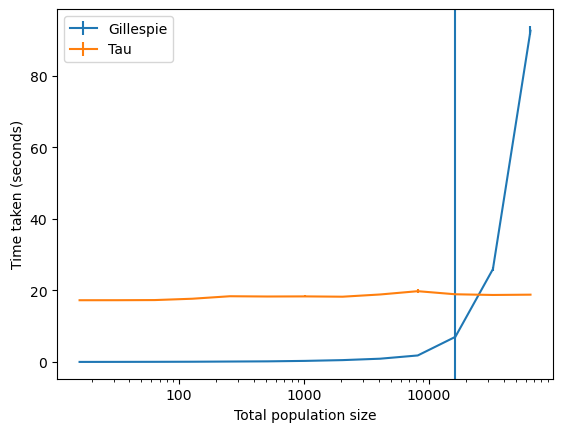

In [20]:
from matplotlib.ticker import ScalarFormatter
fig, ax = plt.subplots()
ax.set_xscale('log')
#ax.set_yscale('log')
Population_graph_series = []

plt.errorbar(Population_series, Gillespie_data[1], yerr = Gillespie_data[-1], label = 'Gillespie')
plt.errorbar(Population_series, Tau_data[1], yerr= Tau_data[-1] , label = 'Tau')
plt.ylabel ('Time taken (seconds)')
plt.xlabel ('Total population size')
for axis in [ax.xaxis, ax.yaxis]:
    formatter = ScalarFormatter()
    formatter.set_scientific(False)
    axis.set_major_formatter(formatter)
plt.legend()
plt.axvline(x = 2**14)
plt.savefig('Efficiency study (Tau vs Gillespie)')
plt.show()

Below we see the average time taken for a population of size $2^{14}$

In [8]:
print(Gillespie_data[1][-1])
print(Tau_data[1][-1])

92.54239928999988
18.809611796000098


And the standard deviation

In [9]:
print(np.sqrt(Gillespie_data[3][-1]))
print(np.sqrt(Tau_data[3][-1]))

4.594003807281769
0.2568184068429643


Below we have histograms for the time taken for all our runs of the HKO and Gillespie algorithm at population size $2^{14}$

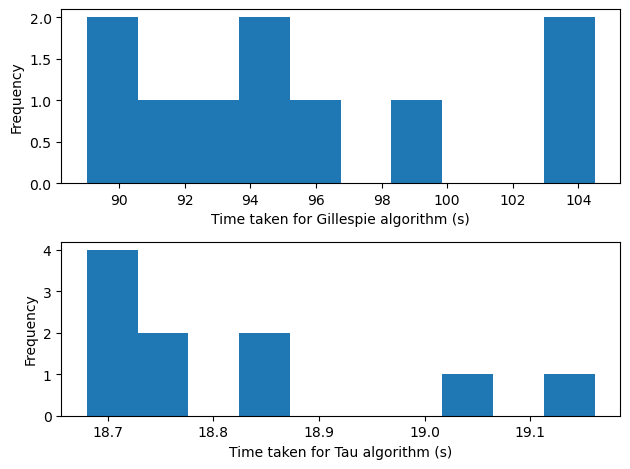

In [10]:
plt.subplot(2, 1, 1)
plt.hist(Gillespie_data[4][-10:,], bins = 10)
plt.ylabel ('Frequency')
plt.xlabel ('Time taken for Gillespie algorithm (s)')
plt.subplot(2, 1, 2)
plt.hist(Tau_data[4][-10:,], bins = 10)
plt.ylabel ('Frequency')
plt.xlabel ('Time taken for Tau algorithm (s)')
plt.tight_layout()
plt.savefig('Histograms efficiency study (2 classes)')
plt.show()